# Classifying the Canopy Height Model

**Aim:** To analyse the Canopy Height Model and use it to classify regions that have short, medium and tall trees.

First import the python packages that will be used in this notebook.



In [1]:
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import numpy as np

import seaborn as sns
from scipy.stats import zscore

Read the Canopy Height Model tiff file containing the data. This is the file that was created in 1-analysing-lidar-data.ipynb.

In [2]:
with rio.open('./pre_chm.tiff') as src:
    # Convert / read the data into a numpy array:
    lidar_chm_im = src.read(masked=True)

    # Create a spatial extent object using rio.plot.plotting
    chm_spatial_extent = rio.plot.plotting_extent(src)
    # Get bounds of object
    chm_bounds = src.bounds
    
    # Determine Coordinate Reference System (CRS):
    chm_crs = src.crs
    
    # Determine the resolution of the LIDAR image:
    chm_resolution = src.res 
    
    # Meta data
    chm_meta = src.meta
    
    chm_mask = src.read_masks(1)

In [3]:
chm_mask.shape

(2000, 4000)

For whatever reasons, the lidar_chm_im mask is the reverse of what it should be. This can be solved using:

In [4]:
lidar_chm_im.mask = ~lidar_chm_im.mask

The type of the object `lidar_dem_im` is:

In [5]:
type(lidar_chm_im)

numpy.ma.core.MaskedArray

The CRS of the raster data is:

In [6]:
chm_crs 

CRS.from_dict(init='epsg:32613')

The resolution of the LIDAR image is:

In [7]:
chm_resolution

(1.0, 1.0)

This means that each elevation pixel corresponds to a 1m x 1m square.

The shape of the object lidar_dem_im is: 

In [8]:
lidar_chm_im.shape

(1, 2000, 4000)

In [9]:
lidar_chm_im = lidar_chm_im.reshape(2000,4000)

Plot the LIDAR image data using code from <a href='https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/open-lidar-raster-python/'>here</a>.

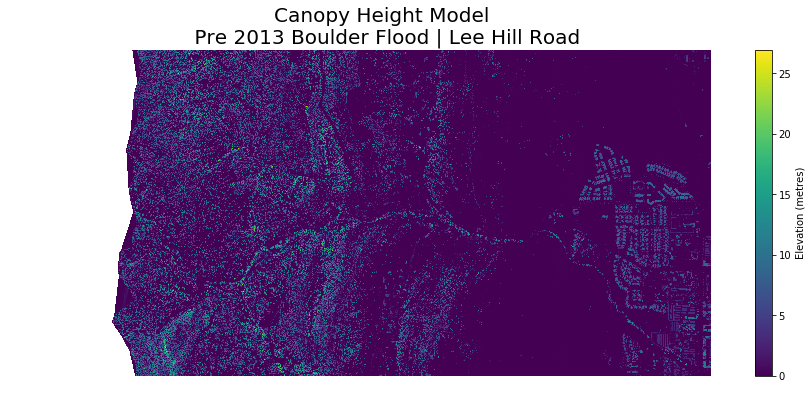

In [10]:
fig, ax = plt.subplots(figsize = (16,6))
lidar_plot = ax.imshow(lidar_chm_im, 
                       cmap='viridis',
                       extent=chm_spatial_extent)
ax.set_title("Canopy Height Model \n Pre 2013 Boulder Flood | Lee Hill Road", fontsize= 20)
fig.colorbar(lidar_plot, label='Elevation (metres)')
# turn off the x and y axes for prettier plotting
ax.set_axis_off()
plt.show()



### Plotting the distribution of elevations in the Canopy Height Model


Flatten the `lidar_chm_im` data into a list.

In [11]:
heights = lidar_chm_im.ravel().tolist()

Filter out the `None` data in the `heights` list and turn the list into a numpy array.

In [12]:
heights = [h for h in heights if h is not None]
heights = np.array(heights)

Define the following tree heights as used in <a href='https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/classify-plot-raster-data-in-python/'>earthdatascience.org</a>:

Below following breaks are used:

    0 - 2 = no trees
    2 - 7 = short trees
    7 - 12 = medium trees
    > 12 = tall trees

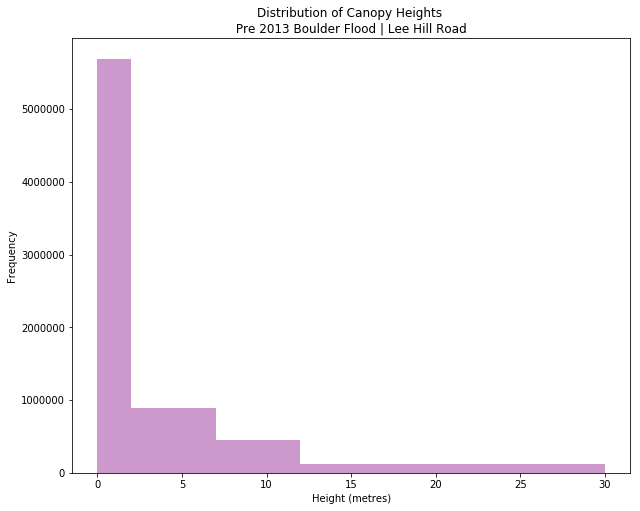

In [13]:
plt.figure(figsize=(10, 8));
sns.distplot(heights, kde=False, bins=[0, 2, 7, 12, 30], color='purple')

plt.xlabel('Height (metres)')
plt.ylabel('Frequency')
plt.title('Distribution of Canopy Heights \n Pre 2013 Boulder Flood | Lee Hill Road ');

## Digitise tree height in the CHM

Define the following categories as used in <a href='https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/classify-plot-raster-data-in-python/'>earthdatascience.org</a>:
    
    <0 meters -> 0 (No data)
    0 - 2 meters -> 1
    2 - 7 meters -> 2 (short trees)
    7 - 12 meters -> 3 (medium trees)
    > 12 or 12 - Inf -> 4 (tall trees)


Define the categories above into a list:

In [14]:
class_boundaries = [lidar_chm_im.min(),2,7,12,np.inf]

Use `np.digitize` to convert the tree heights in the CHM into their respective class.

In [15]:
lidar_chm_im_class = np.digitize(lidar_chm_im, class_boundaries)

Create a mask to hide class 0, the values that represent no data.

In [16]:
lidar_chm_im_class_masked = np.ma.masked_where(lidar_chm_im_class==0, lidar_chm_im_class)

Define the class labels and their respective colour.

In [17]:
class_labels = ['Short trees', 'Less short trees', 'Medium trees','Tall trees']
colours = ['linen', 'lightgreen', 'darkgreen', 'maroon']

Use `Patch` from `matplotlib.patches` to create a set of the patches that will appear in the legend.

In [18]:
legend_patches = [Patch(color=colour, label=label)
                  for colour, label in zip(colours, class_labels)]

Use `ListedColormap` from `matplotlib.colors` to create a colour map using the selected colours.

In [19]:
cmap = ListedColormap(colours)

Create the plot. Code snippet taken directly from <a href='https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/classify-plot-raster-data-in-python/'>earthdatascience.org</a>


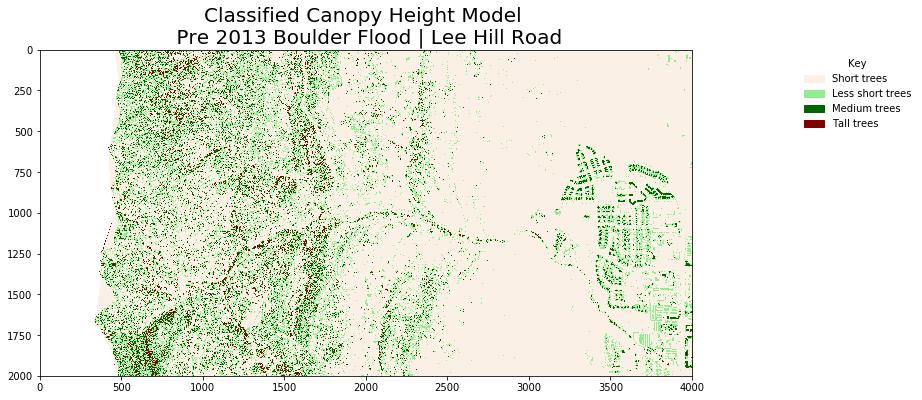

In [20]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(lidar_chm_im_class_masked, 
          cmap=cmap)
ax.set_title('Classified Canopy Height Model \n Pre 2013 Boulder Flood | Lee Hill Road', fontsize=20);
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         bbox_to_anchor = (1.35,1), # Place legend to the RIGHT of the map
         title = 'Key') 

## Plotting the extent of Tall Trees

The aim is to plot the location of Tall Trees. These were previously defined to be trees over 12 metres.

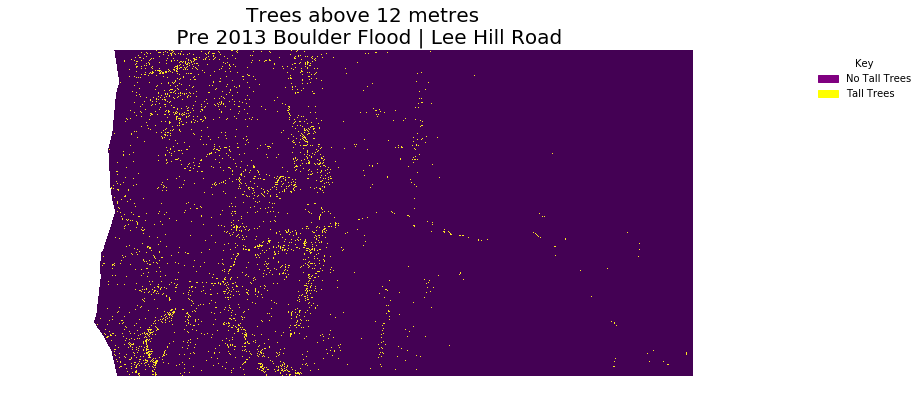

In [21]:
class_labels = ['No Tall Trees', 'Tall Trees']
colours = ['purple', 'yellow']

legend_patches = [Patch(color=colour, label=label)
                  for colour, label in zip(colours, class_labels)]

cmap = ListedColormap(colours)

fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(lidar_chm_im > 12)

ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         bbox_to_anchor = (1.35,1),
         title = 'Key') # Place legend to the RIGHT of the map

ax.set_title('Trees above 12 metres \n Pre 2013 Boulder Flood | Lee Hill Road', fontsize=20)

ax.set_axis_off()